# Part A: Priors for variational autoencoders (VAEs)

##  Show a plot of the prior and the aggregate posterior.

## Discuss and compare across priors the match between the priors and the aggregate posteriors.


## Evaluate the test set log-likelihood as approximated by the ELBO.

## Discuss and compare the test set log-likelihood across priors.

# A standard Gaussian prior

In [ ]:
# Arg parse not working, until I get it to work this would be the code:

In [6]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np

In [3]:
print('hej')

import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm

class GaussianPrior(nn.Module):
    def __init__(self, M):
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net
        self.std = nn.Parameter(torch.ones(28, 28)*0.5, requires_grad=True)

    def forward(self, z):
        logits = self.decoder_net(z)
        return td.Independent(td.Bernoulli(logits=logits), 2)

class VAE(nn.Module):
    def __init__(self, prior, decoder, encoder):
        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        q = self.encoder(x)
        z = q.rsample()
        elbo = torch.mean(self.decoder(z).log_prob(x) - td.kl_divergence(q, self.prior()), dim=0)
        return elbo

    def sample(self, n_samples=1):
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()
    
    def forward(self, x):
        return -self.elbo(x)

def train(model, optimizer, data_loader, epochs, device):
    model.train()

    total_steps = len(data_loader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        data_iter = iter(data_loader)
        for x in data_iter:
            x = x[0].to(device)
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=loss.item(), epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()

if __name__ == "__main__":
    from torchvision import datasets, transforms
    from torchvision.utils import save_image, make_grid
    import glob

    # Load MNIST as binarized at 'thresshold' and create data loaders
    thresshold = 0.5
    mnist_train_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)
    mnist_test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=False, download=True,
                                                                transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)

    # Define prior distribution
    M = 32
    prior = GaussianPrior(M)

    # Define encoder and decoder networks
    encoder_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, M*2),
    )

    decoder_net = nn.Sequential(
        nn.Linear(M, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Unflatten(-1, (28, 28))
    )

    # Define VAE model
    decoder = BernoulliDecoder(decoder_net)
    encoder = GaussianEncoder(encoder_net)
    model = VAE(prior, decoder, encoder).to('cpu')

    # Train model
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer, mnist_train_loader, epochs=10, device='cpu')

    # Save model
    torch.save(model.state_dict(), 'model.pt')

    # Generate samples
    model.eval()
    with torch.no_grad():
        samples = (model.sample(64)).cpu() 
        save_image(samples.view(64, 1, 28, 28), 'samples.png')


hej


100%|██████████| 9912422/9912422 [00:00<00:00, 17050280.65it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65942130.55it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 15240559.12it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12785589.78it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Training: 100%|██████████| 18750/18750 [02:42<00:00, 115.34it/s, epoch=10/10, loss=77.3]


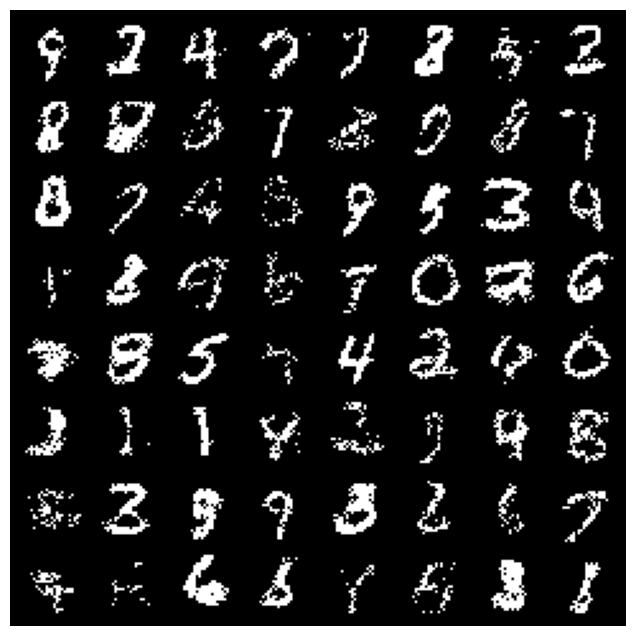

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Loading the generated samples: 
samples_image = Image.open('samples.png')

# Display the samples
plt.figure(figsize=(8, 8))
plt.imshow(samples_image)
plt.axis('off')
plt.show()

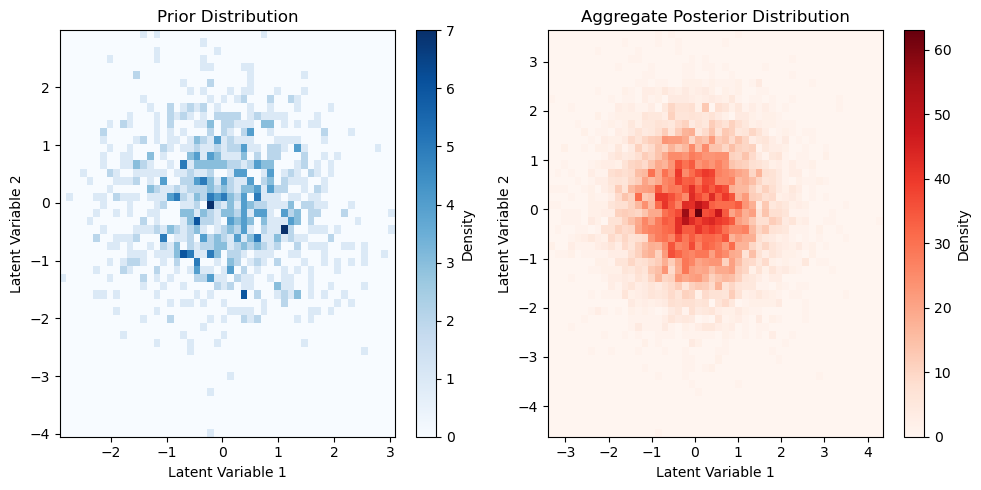

In [7]:
# Generate samples from the prior
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_samples = 1000
prior_samples = prior().sample(torch.Size([n_samples])).detach().cpu().numpy()

# Generate samples from the aggregate posterior
posterior_samples = []
with torch.no_grad():
    for x, _ in mnist_test_loader:
        x = x.to(device)
        q = model.encoder(x)
        z = q.sample()
        posterior_samples.append(z.cpu().numpy())
posterior_samples = np.concatenate(posterior_samples, axis=0)

# Plot prior and aggregate posterior
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Prior Distribution')
plt.hist2d(prior_samples[:, 0], prior_samples[:, 1], bins=50, cmap='Blues')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.subplot(1, 2, 2)
plt.title('Aggregate Posterior Distribution')
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=50, cmap='Reds')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.tight_layout()
plt.show()

# MoG

In [15]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm

class GaussianMixturePrior(nn.Module):
    def __init__(self, M, n_components):

        super(GaussianMixturePrior, self).__init__()
        self.M = M
        self.n_components = n_components
        self.mean = nn.Parameter(torch.zeros(self.n_components, self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.n_components, self.M), requires_grad=False)
        self.log_vars = nn.Parameter(torch.randn(self.n_components, self.M), requires_grad=True)

    def forward(self):
        mix = td.Categorical(torch.ones(self.n_components))
        comp = td.Independent(td.Normal(self.means, torch.exp(0.5*self.log_vars)), 1)
        return td.MixtureSameFamily(mix, comp)

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net
        self.std = nn.Parameter(torch.ones(28, 28)*0.5, requires_grad=True)

    def forward(self, z):
        logits = self.decoder_net(z)
        return td.Independent(td.Bernoulli(logits=logits), 2)

class VAE(nn.Module):
    def __init__(self, prior, decoder, encoder):
        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        q = self.encoder(x)
        z = q.rsample()
        elbo = torch.mean(self.decoder(z).log_prob(x) - td.kl_divergence(q, self.prior()), dim=0)
        return elbo

    def sample(self, n_samples=1):
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()
    
    def forward(self, x):
        return -self.elbo(x)

def train(model, optimizer, data_loader, epochs, device):
    model.train()

    total_steps = len(data_loader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        data_iter = iter(data_loader)
        for x in data_iter:
            x = x[0].to(device)
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=loss.item(), epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()

if __name__ == "__main__":
    from torchvision import datasets, transforms
    from torchvision.utils import save_image, make_grid
    import glob

    # Load MNIST as binarized at 'thresshold' and create data loaders
    thresshold = 0.5
    mnist_train_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)
    mnist_test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=False, download=True,
                                                                transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)

    # Define prior distribution
    M = 32
    prior = GaussianMixturePrior(M,10)

    # Define encoder and decoder networks
    encoder_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, M*2),
    )

    decoder_net = nn.Sequential(
        nn.Linear(M, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Unflatten(-1, (28, 28))
    )

    # Define VAE model
    decoder = BernoulliDecoder(decoder_net)
    encoder = GaussianEncoder(encoder_net)
    model = VAE(prior, decoder, encoder).to('cpu')

    # Train model
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer, mnist_train_loader, epochs=10, device='cpu')

    # Save model
    torch.save(model.state_dict(), 'model2.pt')

    # Generate samples
    model.eval()
    with torch.no_grad():
        samples = (model.sample(64)).cpu() 
        save_image(samples.view(64, 1, 28, 28), 'samples2.png')


Training:   0%|          | 0/18750 [00:00<?, ?it/s]

AttributeError: 'GaussianMixturePrior' object has no attribute 'means'

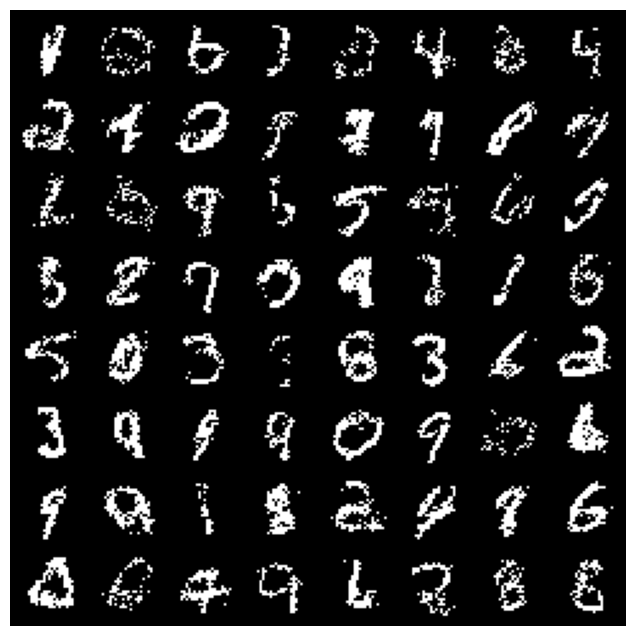

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Loading the generated samples: 
samples_image = Image.open('samples2.png')

# Display the samples
plt.figure(figsize=(8, 8))
plt.imshow(samples_image)
plt.axis('off')
plt.show()

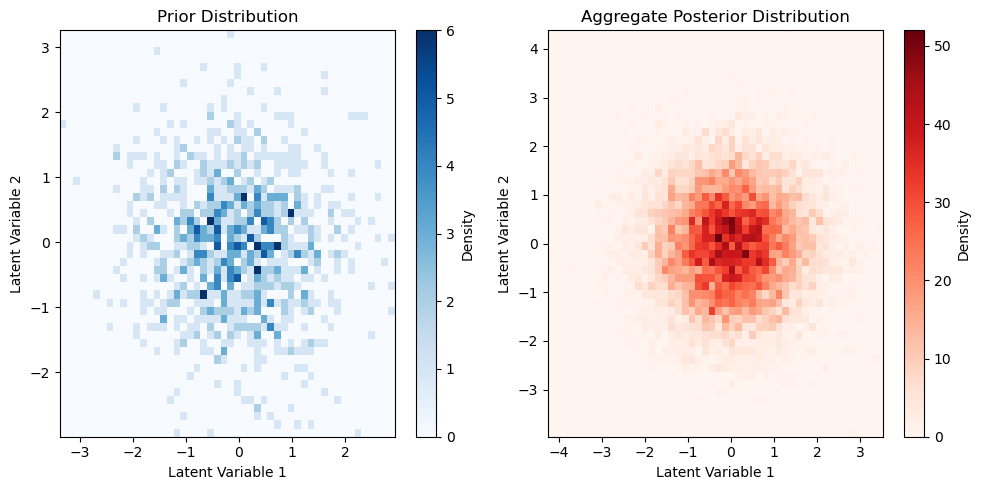

In [10]:
# Generate samples from the prior
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_samples = 1000
prior_samples = prior().sample(torch.Size([n_samples])).detach().cpu().numpy()

# Generate samples from the aggregate posterior
posterior_samples = []
with torch.no_grad():
    for x, _ in mnist_test_loader:
        x = x.to(device)
        q = model.encoder(x)
        z = q.sample()
        posterior_samples.append(z.cpu().numpy())
posterior_samples = np.concatenate(posterior_samples, axis=0)

# Plot prior and aggregate posterior
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Prior Distribution')
plt.hist2d(prior_samples[:, 0], prior_samples[:, 1], bins=50, cmap='Blues')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.subplot(1, 2, 2)
plt.title('Aggregate Posterior Distribution')
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=50, cmap='Reds')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.tight_layout()
plt.show()

# Flow-based prior

In [11]:
class Flow(nn.Module):
    def __init__(self, base, transformations):
        """
        Define a normalizing flow model.
        
        Parameters:
        base: [torch.distributions.Distribution]
            The base distribution.
        transformations: [list of torch.nn.Module]
            A list of transformations to apply to the base distribution.
        """
        super(Flow, self).__init__()
        self.base = base
        self.transformations = nn.ModuleList(transformations)

    def forward(self, z):
        """
        Transform a batch of data through the flow (from the base to data).
        
        Parameters:
        x: [torch.Tensor]
            The input to the transformation of dimension `(batch_size, feature_dim)`
        Returns:
        z: [torch.Tensor]
            The output of the transformation of dimension `(batch_size, feature_dim)`
        sum_log_det_J: [torch.Tensor]
            The sum of the log determinants of the Jacobian matrices of the forward transformations.            
        """
        sum_log_det_J = 0
        for T in self.transformations:
            x, log_det_J = T(z)
            sum_log_det_J += log_det_J
            z = x
        return x, sum_log_det_J
    
    def inverse(self, x):
        """
        Transform a batch of data through the flow (from data to the base).

        Parameters:
        x: [torch.Tensor]
            The input to the inverse transformation of dimension `(batch_size, feature_dim)`
        Returns:
        z: [torch.Tensor]
            The output of the inverse transformation of dimension `(batch_size, feature_dim)`
        sum_log_det_J: [torch.Tensor]
            The sum of the log determinants of the Jacobian matrices of the inverse transformations.
        """
        sum_log_det_J = 0
        for T in reversed(self.transformations):
            z, log_det_J = T.inverse(x)
            sum_log_det_J += log_det_J
            x = z
        return z, sum_log_det_J
    
    def log_prob(self, x):
        """
        Compute the log probability of a batch of data under the flow.

        Parameters:
        x: [torch.Tensor]
            The data of dimension `(batch_size, feature_dim)`
        Returns:
        log_prob: [torch.Tensor]
            The log probability of the data under the flow.
        """
        z, log_det_J = self.inverse(x)
        return self.base().log_prob(z) + log_det_J
    
    def sample(self, sample_shape=(1,)):
        """
        Sample from the flow.

        Parameters:
        n_samples: [int]
            Number of samples to generate.
        Returns:
        z: [torch.Tensor]
            The samples of dimension `(n_samples, feature_dim)`
        """
        z = self.base().sample(sample_shape)
        return self.forward(z)[0]
    
    def loss(self, x):
        """
        Compute the negative mean log likelihood for the given data bath.

        Parameters:
        x: [torch.Tensor] 
            A tensor of dimension `(batch_size, feature_dim)`
        Returns:
        loss: [torch.Tensor]
            The negative mean log likelihood for the given data batch.
        """
        return -torch.mean(self.log_prob(x))

In [12]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm

class FlowBasedPrior(nn.Module):
    def __init__(self, M, n_components):
        super(FlowBasedPrior, self).__init__()
        self.M = M
        self.n_components = n_components
        self.base = td.Normal(torch.zeros(M), torch.ones(M))  # Define base distribution
        transformations = [...]  # Define a list of transformations for the flow
        self.flow = Flow(self.base, transformations)  # Initialize the Flow class

    def forward(self):
        return self.flow()

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net
        self.std = nn.Parameter(torch.ones(28, 28)*0.5, requires_grad=True)

    def forward(self, z):
        logits = self.decoder_net(z)
        return td.Independent(td.Bernoulli(logits=logits), 2)

class VAE(nn.Module):
    def __init__(self, prior, decoder, encoder):
        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        q = self.encoder(x)
        z = q.rsample()
        elbo = torch.mean(self.decoder(z).log_prob(x) - td.kl_divergence(q, self.prior()), dim=0)
        return elbo

    def sample(self, n_samples=1):
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()
    
    def forward(self, x):
        return -self.elbo(x)

def train(model, optimizer, data_loader, epochs, device):
    model.train()

    total_steps = len(data_loader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        data_iter = iter(data_loader)
        for x in data_iter:
            x = x[0].to(device)
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=loss.item(), epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()

if __name__ == "__main__":
    from torchvision import datasets, transforms
    from torchvision.utils import save_image, make_grid
    import glob

    # Load MNIST as binarized at 'thresshold' and create data loaders
    thresshold = 0.5
    mnist_train_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)
    mnist_test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=False, download=True,
                                                                transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)

    # Define prior distribution
    M = 32
    prior = FlowBasedPrior(M)

    # Define encoder and decoder networks
    encoder_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, M*2),
    )

    decoder_net = nn.Sequential(
        nn.Linear(M, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Unflatten(-1, (28, 28))
    )

    # Define VAE model
    decoder = BernoulliDecoder(decoder_net)
    encoder = GaussianEncoder(encoder_net)
    model = VAE(prior, decoder, encoder).to('cpu')

    # Train model
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer, mnist_train_loader, epochs=10, device='cpu')

    # Save model
    torch.save(model.state_dict(), 'model3.pt')

    # Generate samples
    model.eval()
    with torch.no_grad():
        samples = (model.sample(64)).cpu() 
        save_image(samples.view(64, 1, 28, 28), 'samples3.png')


Training: 100%|██████████| 18750/18750 [02:40<00:00, 116.65it/s, epoch=10/10, loss=81.3]


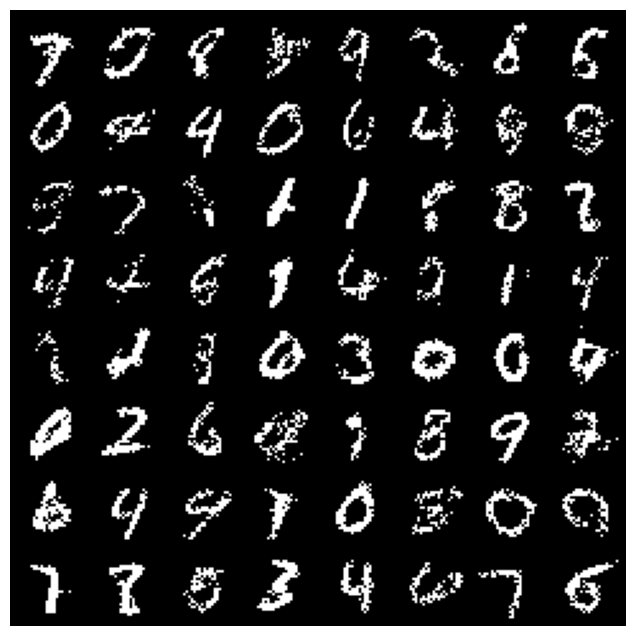

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

# Loading the generated samples: 
samples_image = Image.open('samples3.png')

# Display the samples
plt.figure(figsize=(8, 8))
plt.imshow(samples_image)
plt.axis('off')
plt.show()

In [ ]:
# Generate samples from the prior
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_samples = 1000
prior_samples = prior().sample(torch.Size([n_samples])).detach().cpu().numpy()

# Generate samples from the aggregate posterior
posterior_samples = []
with torch.no_grad():
    for x, _ in mnist_test_loader:
        x = x.to(device)
        q = model.encoder(x)
        z = q.sample()
        posterior_samples.append(z.cpu().numpy())
posterior_samples = np.concatenate(posterior_samples, axis=0)

# Plot prior and aggregate posterior
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Prior Distribution')
plt.hist2d(prior_samples[:, 0], prior_samples[:, 1], bins=50, cmap='Blues')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.subplot(1, 2, 2)
plt.title('Aggregate Posterior Distribution')
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=50, cmap='Reds')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.tight_layout()
plt.show()